# Categorical embedding to model expected sales for product groups.
- [Kaggle notebook](https://www.kaggle.com/mayer79/m5-forecast-keras-with-categorical-embeddings-v2)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# from utils import *
import utils


datapath = os.path.join('data')
cal_filename = 'calendar.csv'    # input
stv_filename = 'sales_train_validation.csv'    # input
ss_filename = 'sample_submission.csv'    # output
sellp_filename = 'sell_prices.csv'    # input
ste_filename = 'sales_train_evaluation.csv'

cal = pd.read_csv(os.path.join(datapath, cal_filename))
stv = pd.read_csv(os.path.join(datapath, stv_filename))
sellp = pd.read_csv(os.path.join(datapath, sellp_filename))
# Not necessary for prototype test
# ss = pd.read_csv(os.path.join(datapath, ss_filename))
# ste = pd.read_csv(os.path.join(datapath, ste_filename))

cal = utils.reduce_mem_usage(cal)
stv = utils.reduce_mem_usage(stv)
sellp = utils.reduce_mem_usage(sellp)
# ss = utils.reduce_mem_usage(ss)
# ste = utils.reduce_mem_usage(ste)

sales = stv
sales['id'] = sales['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))    # remove _validation or _evaluation

d_cols = [c for c in sales.columns if 'd_' in c]    # sales data columns
level_cols = sales.columns[sales.columns.str.contains("d_")==False].values    # level columns

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [2]:
'''
Preprosessing features on calendar
'''
cal = utils.categorize_calendar(cal)
cal.head()

Mem. usage decreased to  0.03 Mb (84.4% reduction)


,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,11101,0,0,0,1,30,4,4,2,0,0,0
1,11101,1,0,0,2,30,4,4,2,0,0,0
2,11101,2,0,0,3,30,4,4,2,0,0,0
3,11101,3,1,0,4,30,4,4,2,1,1,0
4,11101,4,1,0,5,30,4,4,2,1,0,1


In [3]:
'''
Preprosessing and add derived features on selling prices
'''
sellp = utils.prep_selling_prices(sellp)
sellp.head()

Mem. usage decreased to 169.63 Mb (0.0% reduction)


,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,CA_1,HOBBIES_1_001,11325,9.578125,NaN,NaN,0.0
1,CA_1,HOBBIES_1_001,11326,9.578125,0.000000,NaN,0.0
2,CA_1,HOBBIES_1_001,11327,8.257812,-0.137695,NaN,0.0
3,CA_1,HOBBIES_1_001,11328,8.257812,0.000000,NaN,0.0
4,CA_1,HOBBIES_1_001,11329,8.257812,0.000000,NaN,0.0


In [4]:
'''
Preprosessing and add derived features on sales 
'''
sales = utils.reshape_sales(sales, drop_d=1000)    # d_1 to d_drop_d are dropped.
sales = utils.prep_sales(sales)
sales.head()

Mem. usage decreased to 1683.94 Mb (41.5% reduction)


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30
6311430,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,0.399902,0.383301,0.399902,0.511230,0.755859,0.621582
6311431,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,0.166626,0.133301,0.122192,0.144409,0.488037,0.379150
6311432,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,0.433350,0.316650,0.333252,0.166626,0.488037,0.728027
6311433,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,2.433594,2.533203,2.445312,2.339844,1.272461,2.298828
6311434,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,0.700195,0.750000,0.855469,0.816895,1.154297,0.915527


In [5]:
'''
Merge sales with selling prices
'''
sales = sales.merge(cal, how="left", on="d")
gc.collect()
sales = sales.merge(sellp, how="left", on=["wm_yr_wk", "store_id", "item_id"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1208,2.0,0.0,0.714355,...,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,1.0,0.285645,...,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,0.0,0.285645,...,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1208,1.0,4.0,2.572266,...,4,4,2,0,0,0,4.640625,0.0,0.0,0.231201
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1208,0.0,0.0,1.000000,...,4,4,2,0,0,0,3.080078,0.0,0.0,0.375244


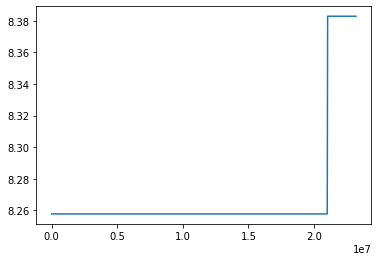

In [13]:
sales[(sales['id']=='HOBBIES_1_001_CA_1')]['sell_price'].plot()

In [10]:
# sales[(sales['id']=='HOBBIES_1_001_CA_1') & (sales['d']==1914)]
# 1969-1208+1=762    # the number of days
# 30490*762=23,233,380
sales.shape

(23233380, 30)

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23233380 entries, 0 to 23233379
Data columns (total 30 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   object 
 1   item_id              object 
 2   dept_id              object 
 3   cat_id               object 
 4   store_id             object 
 5   state_id             object 
 6   d                    int16  
 7   demand               float16
 8   lag_t28              float16
 9   rolling_mean_t7      float16
 10  rolling_mean_t30     float16
 11  rolling_mean_t60     float16
 12  rolling_mean_t90     float16
 13  rolling_mean_t180    float16
 14  rolling_std_t7       float16
 15  rolling_std_t30      float16
 16  wday                 int8   
 17  month                int8   
 18  year                 int8   
 19  event_name_1         int8   
 20  event_type_1         int8   
 21  event_name_2         int8   
 22  event_type_2         int8   
 23  snap_CA              int8   
 

In [14]:
'''
Ordinal encoding of remaining categoricals
'''
from sklearn.preprocessing import OrdinalEncoder

cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

# In loop to minimize memory use
for i, v in tqdm(enumerate(cat_id_cols)):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]])

sales = utils.reduce_mem_usage(sales)
sales.head()
gc.collect()


Mem. usage decreased to 1329.42 Mb (36.2% reduction)


29

In [15]:
'''
Impute numeric columns
'''
num_cols = ["sell_price", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_cumrel",
            "lag_t28", "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", 
            "rolling_mean_t90", "rolling_mean_t180", "rolling_std_t7", "rolling_std_t30"]
bool_cols = ["snap_CA", "snap_TX", "snap_WI"]
dense_cols = num_cols + bool_cols

# Need to do column by column due to memory constraints
for i, v in tqdm(enumerate(num_cols)):
    sales[v] = sales[v].fillna(sales[v].median())
    
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
0,HOBBIES_1_001_CA_1,1437,3,1,0,0,1208,2.0,0.0,0.714355,...,4,4,2,0,0,0,8.257812,0.0,0.0,0.000000
1,HOBBIES_1_002_CA_1,1438,3,1,0,0,1208,1.0,1.0,0.285645,...,4,4,2,0,0,0,3.970703,0.0,0.0,0.000000
2,HOBBIES_1_003_CA_1,1439,3,1,0,0,1208,1.0,0.0,0.285645,...,4,4,2,0,0,0,2.970703,0.0,0.0,0.000000
3,HOBBIES_1_004_CA_1,1440,3,1,0,0,1208,1.0,4.0,2.572266,...,4,4,2,0,0,0,4.640625,0.0,0.0,0.231201
4,HOBBIES_1_005_CA_1,1441,3,1,0,0,1208,0.0,0.0,1.000000,...,4,4,2,0,0,0,3.080078,0.0,0.0,0.375244


In [53]:
a = sales[sales.d >= 1914]
a[(a['id']=='HOBBIES_1_001_CA_1') & (a['d']==1914)]

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
21525940,HOBBIES_1_001_CA_1,1437,3,1,0,0,1914,NaN,1.0,1.142578,...,4,1,1,0,0,0,8.382812,0.0,0.066833,0.053864


In [16]:
'''
Make training data
    # of dense columns: 15
    # of cat columns: 12

X_train:
    d_1208 - d_1885 (1913-28=1885) (678 days)
    # of rows : 30,490 x 678 = 20,672,220
y_train:
    # of sales for 20,672,220 days

So, there are 20,672,220 (input, output) pairs.

Validation set:
    target: d_1886 - d_1913 (28 days)
    # of rows : 30,490 x 28 = 853,720
Test set:
    target: d_1914 - d_1941 (28 days)
    # of rows : 30,490 x 28 = 853,720
'''

test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))
test.head()
gc.collect()

# Submission data
X_test = utils.make_X(test, dense_cols, cat_cols)

# One month of validation data
flag = (sales.d < 1914) & (sales.d >= 1914 - 28)
X_valid = utils.make_X(sales[flag], dense_cols, cat_cols)
y_valid = sales["demand"][flag]

# Rest is used for training
flag = sales.d < 1914 - 28
X_train = utils.make_X(sales[flag], dense_cols, cat_cols)
y_train = sales["demand"][flag]
                             
del flag
gc.collect()

X_train.keys()
# Resetting ordinal encoder
data_info = {'item_id': 3049, 'dept_id': 7, 'store_id': 10, 'cat_id': 3, 'state_id': 3, 
             'wday': 7, 'month': 12, 'year': 6, 
             'event_name_1': 31, 'event_type_1': 5, 'event_name_2': 5, 'event_type_2': 5, 
             'dense1': 15}

print(data_info)

{'item_id': 3049, 'dept_id': 7, 'store_id': 10, 'cat_id': 3, 'state_id': 3, 'wday': 7, 'month': 12, 'year': 6, 'event_name_1': 31, 'event_type_1': 5, 'event_name_2': 5, 'event_type_2': 5, 'dense1': 15}


In [18]:
X_valid['year'].shape

(853720, 1)

## PyTorch Model (slow?)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

from model import Net
from dataloader import M5Dataset, transform_tensor_type


device = torch.device("cuda:1")

model = Net(data_info).to(device)

lr = 0.0002
total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

loss_task = nn.MSELoss()    # return scalar (reduction=mean)
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.RMSprop(model.parameters(), lr=lr)


# data_info: (key, dimension or num_embeddings)
print(data_info)



# Data loader
X_train_tensor = transform_tensor_type(X_train, device)    # tensorize
X_train_tensor['y'] = torch.tensor(y_train.to_numpy(), dtype=torch.float, device=device)

X_val_tensor = transform_tensor_type(X_valid, device)
X_val_tensor['y'] = torch.tensor(y_valid.to_numpy(), dtype=torch.float, device=device)
gc.collect()

train_data = X_train_tensor
train_dataset = M5Dataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)

val_data = X_val_tensor
val_dataset = M5Dataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=10000)

total parameters: 25837
{'item_id': 3049, 'dept_id': 7, 'store_id': 10, 'cat_id': 3, 'state_id': 3, 'wday': 7, 'month': 12, 'year': 6, 'event_name_1': 31, 'event_type_1': 5, 'event_name_2': 5, 'event_type_2': 5, 'dense1': 15}
M5 dataset keys: dict_keys(['dense1', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'y'])
M5 dataset keys: dict_keys(['dense1', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'y'])


In [ ]:
epochs = 30
log_interval = 100
val_freq = 1
saved_filename = 'cat-emb-mlp.pt'
saved_filename =  os.path.join('saved_models', saved_filename)
print('saved_filename: {}\n'.format(saved_filename))
best_val_loss = float('inf')


# Training

for epoch in range(1, epochs+1):
    model.train()
    loop = tqdm(train_loader)    
    for batch_data in loop:
        output = model(batch_data)
        target = batch_data['y']
                
        loss_state = loss_task(output, target)    # state prediction
        
    
        loss = loss_state
        loss.backward()
        optimizer.step()
        
        
        loop.set_description('[Train] Epoch {}/{}'.format(epoch, epochs))
        loop.set_postfix(loss=loss.item())

    # Evaluate on validation set
    if epoch % val_freq == 0:
        model.eval()
        with torch.no_grad():
            val_loss = []
            for val_batch_data in val_loader:
                output = model(val_batch_data)
                target = val_batch_data['y']

                val_loss.append(loss_task(output, target).item())
            val_loss = np.mean(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print('[Valid] Epoch: {} Loss: {:.6f}\t best model is updated'
                  .format(epoch, best_val_loss))
            torch.save({
                'epoch': epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss
            }, saved_filename)
        else:
            print('[Valid] Epoch: {} Loss: {:.6f}'.format(epoch, val_loss))
            



## Tensorflow model

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, Layer
from tensorflow.keras.models import Model


    
def create_model(lr=0.002):
    tf.random.set_seed(173)

    tf.keras.backend.clear_session()
    gc.collect()

    # Dense input
    dense_input = Input(shape=(len(dense_cols), ), name='dense1')

    # Embedding input
    wday_input = Input(shape=(1,), name='wday')
    month_input = Input(shape=(1,), name='month')
    year_input = Input(shape=(1,), name='year')
    event_name_1_input = Input(shape=(1,), name='event_name_1')
    event_type_1_input = Input(shape=(1,), name='event_type_1')
    event_name_2_input = Input(shape=(1,), name='event_name_2')
    event_type_2_input = Input(shape=(1,), name='event_type_2')
    item_id_input = Input(shape=(1,), name='item_id')
    dept_id_input = Input(shape=(1,), name='dept_id')
    store_id_input = Input(shape=(1,), name='store_id')
    cat_id_input = Input(shape=(1,), name='cat_id')
    state_id_input = Input(shape=(1,), name='state_id')

    wday_emb = Flatten()(Embedding(7, 1)(wday_input))
    month_emb = Flatten()(Embedding(12, 1)(month_input))
    year_emb = Flatten()(Embedding(6, 1)(year_input))
    event_name_1_emb = Flatten()(Embedding(31, 1)(event_name_1_input))
    event_type_1_emb = Flatten()(Embedding(5, 1)(event_type_1_input))
    event_name_2_emb = Flatten()(Embedding(5, 1)(event_name_2_input))
    event_type_2_emb = Flatten()(Embedding(5, 1)(event_type_2_input))

    item_id_emb = Flatten()(Embedding(3049, 3)(item_id_input))
    dept_id_emb = Flatten()(Embedding(7, 1)(dept_id_input))
    store_id_emb = Flatten()(Embedding(10, 1)(store_id_input))
    cat_id_emb = Flatten()(Embedding(3, 1)(cat_id_input))
    state_id_emb = Flatten()(Embedding(3, 1)(state_id_input))


    # Combine dense and embedding parts and add dense layers. Exit on linear scale.
    x = concatenate([dense_input, wday_emb, month_emb, year_emb, 
                     event_name_1_emb, event_type_1_emb, 
                     event_name_2_emb, event_type_2_emb, 
                     item_id_emb, dept_id_emb, store_id_emb,
                     cat_id_emb, state_id_emb])
    x = Dense(150, activation="tanh")(x)
    x = Dense(75, activation="tanh")(x)
    x = Dense(10, activation="tanh")(x)
    outputs = Dense(1, activation="linear", name='output')(x)

    inputs = {"dense1": dense_input, "wday": wday_input, "month": month_input, "year": year_input, 
              "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
              "event_name_2": event_name_2_input, "event_type_2": event_type_2_input,
              "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input, 
              "cat_id": cat_id_input, "state_id": state_id_input}

    # Connect input and output
    model = Model(inputs, outputs)

    def my_loss_fn(y_true, y_pred):
        abs_difference = tf.abs(y_true - y_pred)
        return tf.reduce_mean(abs_difference, axis=-1)
        
#     model.compile(loss=keras.losses.mean_squared_error,
#                   metrics=["mse"],
#                   optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    model.compile(loss=my_loss_fn,
                  metrics=["mse"],
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr))
    return model

model = create_model(0.0002)
model.summary()
# keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [250]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten, Layer
from tensorflow.keras.models import Model


class MyActivityRegularizer(Layer):
    """Layer that creates an activity sparsity regularization loss."""

    def __init__(self, rate=1e-2):
        super(MyActivityRegularizer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # We use `add_loss` to create a regularization loss
        # that depends on the inputs.
        self.add_loss(self.rate * tf.reduce_sum(tf.square(inputs)))
        return inputs


class Net(Model):
    
    def __init__(self, threshold=0.7):
        super(Net, self).__init__()
        self.reg = MyActivityRegularizer()
        
        gc.collect()
        
        # Dense input
#         self.dense_input = Input(shape=(len(dense_cols), ), name='dense1')

        # Embedding input
        self.wday_layer = Embedding(7, 1)
        self.month_layer = Embedding(12, 1)
        self.year_layer = Embedding(6, 1)
        self.event_name_1_layer = Embedding(31, 1)
        self.event_type_1_layer = Embedding(5, 1)
        self.event_name_2_layer = Embedding(5, 1)
        self.event_type_2_layer = Embedding(5, 1)
        self.item_id_layer = Embedding(3049, 3)
        self.dept_id_layer = Embedding(7, 1)
        self.store_id_layer = Embedding(10, 1)
        self.cat_id_layer = Embedding(3, 1)
        self.state_id_layer = Embedding(3, 1)
        
        self.dense1 = Dense(150, activation='tanh')
        self.dense2 = Dense(75, activation='tanh')
        self.dense3 = Dense(10, activation='tanh')
        self.dense4 = Dense(1, activation='linear')
        
        self.aux_dense1 = Dense(16, activation='tanh')
        self.aux_dense2 = Dense(1, activation='relu')
        self.aux_relu = keras.layers.ReLU(threshold=threshold)
    
    def call(self, inputs):
        wday_emb = Flatten()(self.wday_layer(inputs['wday']))
        month_emb = Flatten()(self.month_layer(inputs['month']))
        year_emb = Flatten()(self.year_layer(inputs['year']))
        event_name_1_emb = Flatten()(self.event_name_1_layer(inputs['event_name_1']))
        event_type_1_emb = Flatten()(self.event_type_1_layer(inputs['event_type_1']))
        event_name_2_emb = Flatten()(self.event_name_2_layer(inputs['event_name_2']))
        event_type_2_emb = Flatten()(self.event_type_2_layer(inputs['event_type_2']))

        item_id_emb = Flatten()(self.item_id_layer(inputs['item_id']))
        dept_id_emb = Flatten()(self.dept_id_layer(inputs['dept_id']))
        store_id_emb = Flatten()(self.store_id_layer(inputs['store_id']))
        cat_id_emb = Flatten()(self.cat_id_layer(inputs['cat_id']))
        state_id_emb = Flatten()(self.state_id_layer(inputs['state_id']))
    
        # Combine dense and embedding parts and add dense layers. Exit on linear scale.
        x = concatenate([inputs['dense1'], wday_emb, month_emb, year_emb, 
                         event_name_1_emb, event_type_1_emb, 
                         event_name_2_emb, event_type_2_emb, 
                         item_id_emb, dept_id_emb, store_id_emb,
                         cat_id_emb, state_id_emb])
        x = self.dense1(x)
#         x = self.reg(x)    # check
        self.add_loss(1e-2 * tf.reduce_sum(tf.square(x)))
        x = self.dense2(x)
        x = self.dense3(x)
        outputs = self.dense4(x)    # (batch, 1)
        
        # aux path
        aux_item_id_emb = Flatten()(self.item_id_layer(inputs['item_id']))
        aux_x = self.aux_dense1(aux_item_id_emb)
        aux_x = self.aux_dense2(aux_x)
        aux_threshold = self.aux_relu(inputs['dense1'][:,1:2])
        aux_x = aux_threshold*aux_x    # (batch, 1)
        
        outputs -= aux_x
        
        return outputs

# Set a model
model = Net(0.0)

        
model.compile(loss=keras.losses.mean_squared_error,
              metrics=["mse"],
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0002))

In [251]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=10000,
                    epochs=30,
                    shuffle=True,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
2068/2068 [==============================] - 17s 8ms/step - loss: 403.2675 - mse: 9.6314 - val_loss: 12.2895 - val_mse: 8.9082
Epoch 2/30
2068/2068 [==============================] - 17s 8ms/step - loss: 9.9300 - mse: 8.4577 - val_loss: 8.1492 - val_mse: 7.5461
Epoch 3/30
2068/2068 [==============================] - 17s 8ms/step - loss: 8.3160 - mse: 7.8026 - val_loss: 7.2495 - val_mse: 6.8858
Epoch 4/30
2068/2068 [==============================] - 17s 8ms/step - loss: 7.7528 - mse: 7.3796 - val_loss: 6.7352 - val_mse: 6.4800
Epoch 5/30
2068/2068 [==============================] - 17s 8ms/step - loss: 7.3805 - mse: 7.0875 - val_loss: 6.3859 - val_mse: 6.2153
Epoch 6/30
2068/2068 [==============================] - 17s 8ms/step - loss: 7.1077 - mse: 6.8688 - val_loss: 6.4794 - val_mse: 6.3224
Epoch 7/30
2068/2068 [==============================] - 17s 8ms/step - loss: 6.9207 - mse: 6.7121 - val_loss: 6.4257 - val_mse: 6.2389
Epoch 8/30
2068/2068 [==============================

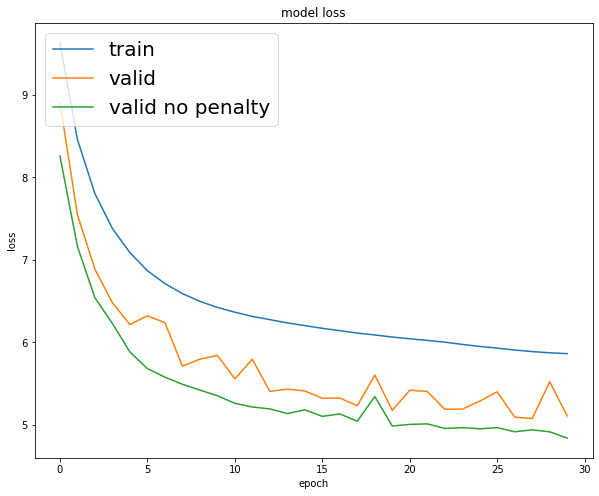

In [255]:
history.history['val_mse_penalty'] = np.array([8.258187294006348, 7.162240505218506, 6.539510250091553, 6.229251861572266,
                                               5.88347864151001, 5.681701183319092, 5.578675746917725, 5.4920973777771,
                                               5.421908378601074, 5.353339672088623, 5.261537551879883, 5.216814041137695,
                                               5.193465709686279, 5.137282848358154, 5.182275772094727, 5.103191375732422,
                                               5.132889747619629, 5.044410228729248, 5.343522548675537, 4.986263275146484, 
                                               5.005681037902832, 5.012467861175537, 4.9569783210754395, 4.966399192810059,
                                               4.952366828918457, 4.96635627746582, 4.9167561531066895, 4.939964294433594, 
                                               4.91628885269165, 4.840700626373291])

plt.figure(0, figsize=(10,8))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.plot(history.history['val_mse_penalty'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid', 'valid no penalty'], loc='upper left', fontsize=20)
plt.show()

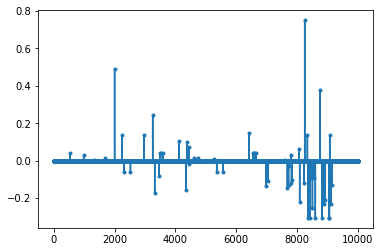

In [151]:
# 8247, 12476, 14480, 14774, 14873, 15119, 15129, 15877, 16061, 16138 : 70% increased price
# 20625526, 20626432, 20630378, 20639958, 20646116, 20655014, 20656016, 20656922, 20660868, 20670448 : 70% increased price
a = X_train['dense1'][:,1]

plt.plot(a[:10000], '.-')

In [176]:
np.where(a>0.7)[0][-10:]

array([20625526, 20626432, 20630378, 20639958, 20646116, 20655014,
       20656016, 20656922, 20660868, 20670448])

In [199]:
idx = 20625526
ddx = sales.iloc[idx]['d']
full_id = sales.iloc[idx]['id']
item_id, store_id = '_'.join(sales.iloc[idx]['id'].split('_')[:3]), '_'.join(sales.iloc[idx]['id'].split('_')[-2:])
sales[idx-1:idx][['id', 'd', 'demand', 'sell_price', 'sell_price_rel_diff']]

,id,d,demand,sell_price,sell_price_rel_diff
20625525,FOODS_2_263_TX_1,1884,0.0,5.921875,0.0


In [197]:
item_id, store_id, wdx

('FOODS_2_264', 'TX_1', 11609)

In [196]:
# sales[(sales['id']=='FOODS_2_323_CA_3') & (sales['d']==1208)]
wdx = cal[cal['d']==ddx]['wm_yr_wk'].item()
cal[cal['d']==ddx]

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1883,11609,0,2,5,1884,30,4,4,2,0,0,0


In [198]:
sellp[(wdx-2<sellp['wm_yr_wk']) & (sellp['wm_yr_wk']<=wdx) & (sellp['item_id']==item_id) & (sellp['store_id']==store_id)]

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
3190009,TX_1,FOODS_2_264,11608,1.990234,-0.498535,0.748535,0.140869
3190010,TX_1,FOODS_2_264,11609,3.970703,0.995117,0.748535,0.709961


In [200]:
sales[(ddx-2<sales['d']) & (sales['d']<=ddx) & (sales['id']==full_id)]
# sales.iloc[8247]

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_roll_sd7,sell_price_cumrel
20595036,FOODS_2_264_TX_1,478,1,0,4,1,1883,0.0,0.0,0.285645,...,4,4,2,0,0,0,1.990234,-0.498535,0.748535,0.140869
20625526,FOODS_2_264_TX_1,478,1,0,4,1,1884,0.0,0.0,0.285645,...,4,4,2,0,0,0,3.970703,0.995117,0.748535,0.709961


In [228]:
filtered_idx = sales[sales['sell_price_rel_diff'] > 0.7].index
ret = []
num_valid = 0
for fid in tqdm(filtered_idx):
    full_id, ddx, demand = sales.loc[fid, ['id', 'd', 'demand']]
#     print(full_id, ddx, demand)
    try:
        prev_demand = sales[(sales['d']==ddx-1) & (sales['id']==full_id)]['demand'].item()
    except:
        continue
    
    num_valid += 1
    if demand < prev_demand:
        ret.append(fid)
#         print(sales[(sales['d']==ddx-1) & (sales['id']==full_id)].loc[:, ['id', 'd', 'demand']])

In [233]:
len(ret)/num_valid

0.2273416540300945

In [116]:
from tensorflow.keras.layers import Layer, Dense



class MyActivityRegularizer(Layer):
    """Layer that creates an activity sparsity regularization loss."""
    def __init__(self, rate=1e-2):
        super(MyActivityRegularizer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # We use `add_loss` to create a regularization loss
        # that depends on the inputs.
        self.add_loss(self.rate * tf.reduce_sum(tf.square(inputs)))
        return inputs
    
class SparseMLP(Model):
    """Stack of Linear layers with a sparsity regularization loss."""

    def __init__(self, output_dim):
        super(SparseMLP, self).__init__()
        self.dense_1 = Dense(32, activation=tf.nn.relu)
#         self.regularization = MyActivityRegularizer(1e-2)
        self.dense_2 = Dense(output_dim)

    def call(self, inputs):
        x = self.dense_1(inputs)
#         x = self.regularization(x)
#         random_weight = tf.random.uniform(shape=[1])
        random_weight = np.random.uniform()
        self.add_loss(random_weight * tf.reduce_sum(tf.square(x)))
#         self.add_loss(1e-2 * tf.reduce_sum(tf.square(x)))
        return self.dense_2(x)


mlp = SparseMLP(1)
y = mlp(tf.ones((10, 10)))

print(mlp.losses)  # List containing one float32 scalar

mlp.compile(#loss=keras.losses.mean_absolute_error,
              metrics=["mae"],
              optimizer=keras.optimizers.RMSprop(learning_rate=0.0001))

# model.summary()

mlp.fit(x=tf.ones((10, 10)), y=tf.ones((10, 1)))

[<tf.Tensor: shape=(), dtype=float32, numpy=21.821466>]
1/1 [==============================] - 0s 1ms/step - loss: 12.8968 - mae: 1.2549


In [102]:
np.random.uniform()

0.222100587272269

In [75]:
# mlp(tf.ones((1, 10)))

mlp.evaluate(tf.ones((1, 10)), y=tf.ones((1,1)))
# 1e-2*tf.reduce_sum(tf.square(mlp.dense_1(tf.ones((1, 10)))))

1/1 [==============================] - 0s 921us/step - loss: 1.6855 - mae: 1.5982


[1.6855241060256958, 1.5981512069702148]

In [77]:
1e-2*tf.reduce_sum(tf.square(mlp.dense_1(tf.ones((1, 10)))))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0873729>

In [78]:
0.0873729 + 1.5981512069702148

1.685524106970215

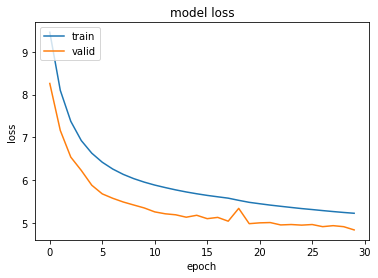

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [113]:
class OuterLayerWithKernelRegularizer(keras.layers.Layer):
    def __init__(self):
        super(OuterLayerWithKernelRegularizer, self).__init__()
        self.dense = keras.layers.Dense(
            32, kernel_regularizer=tf.keras.regularizers.l2(1e-3)
        )

    def call(self, inputs):
        return self.dense(inputs)


layer = OuterLayerWithKernelRegularizer()
_ = layer(tf.zeros((1, 1)))

# This is `1e-3 * sum(layer.dense.kernel ** 2)`,
# created by the `kernel_regularizer` above.
print(layer.losses)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.002366073>]
